# NetMap Tutorial & Use Case

#### Welcome to the NetMap Tutorial

This notebook provides a guided, end-to-end introduction to NetMap, covering the complete workflow from installation to interpretation of results.\
By working through the sections below, you will learn how to configure the environment, process your data, and generate meaningful network-based insights.

This tutorial will walk you through:

1. Installing and configuring NetMap

2. Running downstream filtering

3. Performing network analyses

4. Visualizing networks of interest

In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.pyplot import rc_context
import numpy as np

# Number of cores to use
ncores = 64

import sys


from netmap.downstream import final_downstream


import warnings
warnings.filterwarnings("ignore")

from netmap.utils.data_utils import *
from netmap.utils.tf_utils import *
from netmap.utils.netmap_config import NetmapConfig

from netmap.model.train_model import create_model_zoo
from netmap.grn.inferrence import inferrence, inferrence_model_wise
from netmap.masking.internal import *
from netmap.masking.external import *

from netmap.downstream.edge_selection import *
from netmap.downstream.clustering import *
from netmap.downstream.final_downstream import *

import scipy.sparse as scs

import torch

#### Default Parameters

top_edges = 0.3 | percentage_1 = 0.3 | percentage_2 = 0.7 | top_per_source = 1000 | min_reg_size = 100 | keep_top = 750

In [ ]:
# set output directory
output_dir = "/data_nfs/og86asub/netmap/netmap-evaluation/netmap/tutorials/use_case_outputs/"

# Create both directories regardless of whether they already exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, "networks"), exist_ok=True)

In [3]:

adata = sc.datasets.pbmc3k()


In [ ]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [5]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [6]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

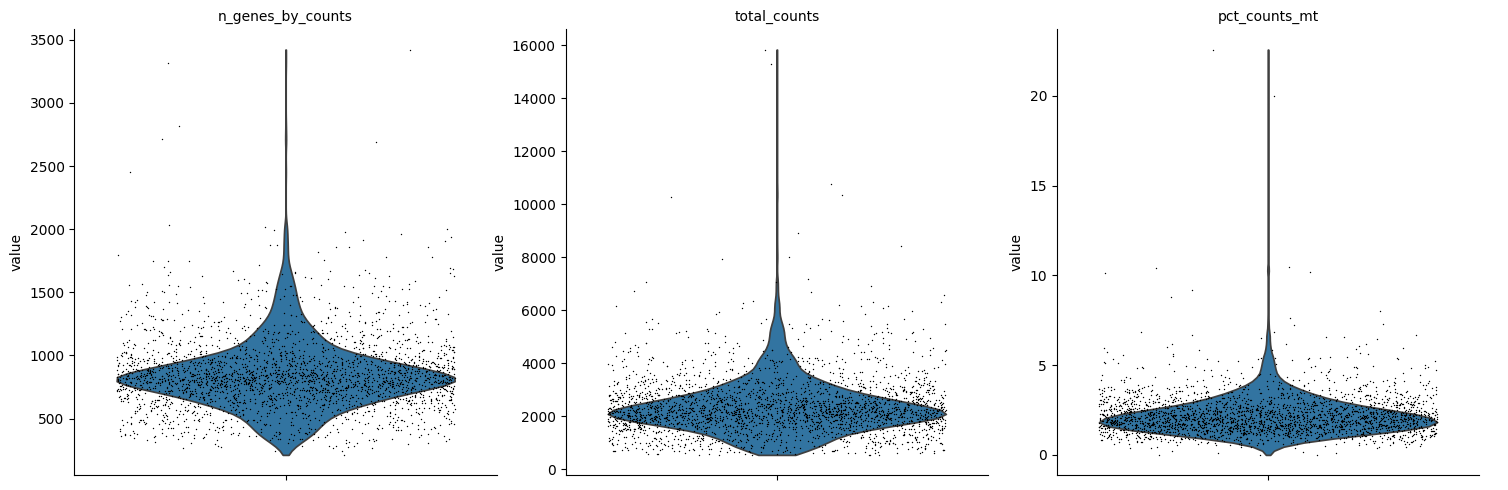

In [7]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

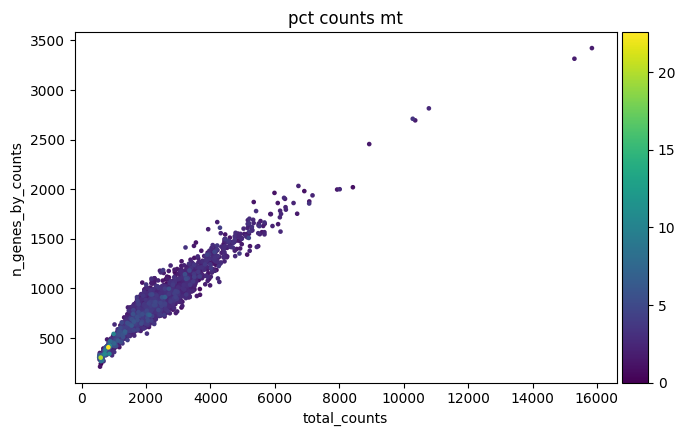

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=50)


In [10]:
sc.pp.scrublet(adata)

In [ ]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [ ]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [13]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

In [14]:
adata = adata[:, adata.var.pct_dropout_by_counts<90 ]
adata = adata[:, adata.var.highly_variable == True]

In [15]:
adata

View of AnnData object with n_obs × n_vars = 2700 × 960
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scrublet', 'log1p', 'hvg'
    layers: 'counts'

In [16]:
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=20)
sc.tl.leiden(adata, resolution=0.1)


In [17]:
sc.tl.umap(adata)

## Input data
1. Netmap required unscaled counts as input data. 
2. Create a tensor dataset
3. Create a set of models specified by n_models
4. You can set the number of epochs larger, early stopping is implemented based on an 80:20 split.
5. No drop out was helpful on simulated data. 
6. Architechture appeared to make no difference on simulated data, but research has shown deeper architechtures could benefit clustering.

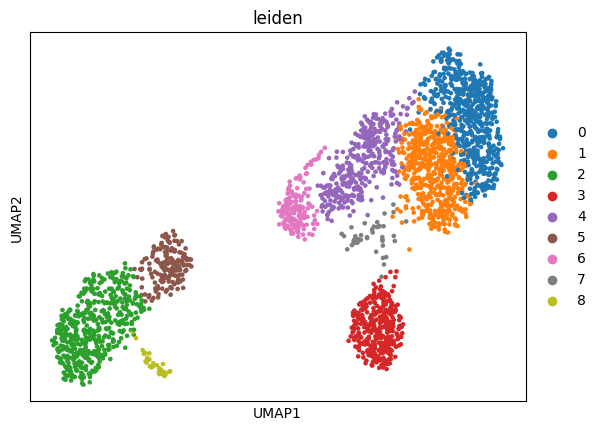

In [108]:
sc.tl.leiden(adata, resolution=0.8)

sc.pl.umap(adata, color = 'leiden')

In [19]:

gene_names = np.array(adata.var.index)
data_tensor = adata.X


if scs.issparse(data_tensor):
    data_tensor = torch.tensor(data_tensor.todense(), dtype=torch.float32)
else:
    data_tensor = torch.tensor(data_tensor, dtype=torch.float32)

use_case_path = '/data_nfs/og86asub/netmap/netmap-evaluation/netmap/tutorials/use_case_data/use_case/scanpy/'
os.makedirs(use_case_path, exist_ok=True)

model_zoo = create_model_zoo(data_tensor,  n_models=10, n_epochs=10000, model_type='ZINBAutoencoder', latent_dim= 8, dropout_rate=0.1, hidden_dim = [64] )

#grn_adata.write_h5ad( '/data_nfs/og86asub/netmap/netmap-evaluation/netmap/tutorials/use_case_data/use_case/scanpy/grn_adata_new.h5ad')



Training Autoencoder:   2%|▏         | 179/10000 [00:26<24:00,  6.82it/s, best_val=0.2719, train_loss=0.2687, val_loss=0.2711]


Early stopping triggered after 180 epochs due to no improvement in validation loss (Best Loss: 0.2719).


Training Autoencoder:   2%|▏         | 159/10000 [00:23<24:20,  6.74it/s, best_val=0.2669, train_loss=0.2698, val_loss=0.2660]


Early stopping triggered after 160 epochs due to no improvement in validation loss (Best Loss: 0.2669).


Training Autoencoder:   2%|▏         | 179/10000 [00:26<23:57,  6.83it/s, best_val=0.2745, train_loss=0.2678, val_loss=0.2736]


Early stopping triggered after 180 epochs due to no improvement in validation loss (Best Loss: 0.2745).


Training Autoencoder:   2%|▏         | 159/10000 [00:23<24:18,  6.75it/s, best_val=0.2704, train_loss=0.2692, val_loss=0.2695]


Early stopping triggered after 160 epochs due to no improvement in validation loss (Best Loss: 0.2704).


Training Autoencoder:   2%|▏         | 159/10000 [00:23<24:22,  6.73it/s, best_val=0.2693, train_loss=0.2692, val_loss=0.2683]


Early stopping triggered after 160 epochs due to no improvement in validation loss (Best Loss: 0.2693).


Training Autoencoder:   3%|▎         | 259/10000 [00:37<23:20,  6.96it/s, best_val=0.2723, train_loss=0.2678, val_loss=0.2720]


Early stopping triggered after 260 epochs due to no improvement in validation loss (Best Loss: 0.2723).


Training Autoencoder:   2%|▏         | 169/10000 [00:25<24:14,  6.76it/s, best_val=0.2697, train_loss=0.2691, val_loss=0.2691]


Early stopping triggered after 170 epochs due to no improvement in validation loss (Best Loss: 0.2697).


Training Autoencoder:   2%|▏         | 169/10000 [00:24<23:19,  7.03it/s, best_val=0.2713, train_loss=0.2688, val_loss=0.2705]


Early stopping triggered after 170 epochs due to no improvement in validation loss (Best Loss: 0.2713).


Training Autoencoder:   2%|▏         | 229/10000 [00:34<24:14,  6.72it/s, best_val=0.2726, train_loss=0.2677, val_loss=0.2723]


Early stopping triggered after 230 epochs due to no improvement in validation loss (Best Loss: 0.2726).


Training Autoencoder:   3%|▎         | 259/10000 [00:37<23:33,  6.89it/s, best_val=0.2695, train_loss=0.2683, val_loss=0.2692]

Early stopping triggered after 260 epochs due to no improvement in validation loss (Best Loss: 0.2695).


## Run the inference process on all datasets.
1. The tensor does not have naming information, therefore gene_names must correspond to the correct ordering of the genes in the columns of the tensor.
2. Gradient Shap obtained the best results across a range of test setups on simulated data. 

In [20]:
#grn_adata = inference(model_zoo, data_tensor.cuda(), gene_names, xai_method='GradientShap')

In [21]:
#use_case_path = '/data_nfs/og86asub/netmap/netmap-evaluation/netmap/tutorials/use_case_data/use_case/FOXA3_CEBPA/'

In [22]:
#grn_adata.write_h5ad( '/data_nfs/og86asub/netmap/netmap-evaluation/netmap/tutorials/use_case_data/use_case/FOXA3_CEBPA/grn_adata_new.h5ad')

In [23]:
grn_adata = inferrence(model_zoo, data_tensor.cuda(), gene_names, xai_method='GradientShap', background_type = 'zeros')


100%|██████████| 960/960 [20:45<00:00,  1.30s/it]


Creating anndata
Setting vars


The gene-gene interection data as it is now is unfittred and contains all possible interactions.\
We will filter it based on the default parameters.\
This will make the data more manageable and focus on the most relevant interactions.

In [ ]:
# Apply source is a TF annotation to filter the GRN to only include relevant TFs
import pandas as pd
tfs_list = pd.read_csv('/data_nfs/og86asub/netmap/netmap-evaluation/data/annotation//allTFs_hg38.txt', header=None)[0].tolist()

grn_adata_smol = grn_adata[:, grn_adata.var["source"].isin(tfs_list)].copy()
print(f"AnnData shape: {grn_adata.shape}")



AnnData shape: (2700, 921600)


Step 1: Global Edge Filtering

In this step, we apply global edge filtering to reduce the gene regulatory network (GRN) to only its most informative edges. 
This procedure removes low-confidence or low-frequency edges across the dataset, allowing subsequent clustering and visualization steps to operate on a cleaner, more interpretable graph.\
You will specify two key parameters:

1. top_edges: The proportion of highest-weight edges to retain globally. For example, 0.3 keeps the top 30% of edges across all cells.
2. n_clu: The number of clusters in the data.

In [25]:
# Parameters setting
top_edges = 0.1
n_clu = 3


In [ ]:

grn_adata_smol = add_top_edge_annotation_global(grn_adata_smol, top_edges=[top_edges], nan_fill=0)

filter_key = f"global_cell_count_{top_edges}"



In [47]:
grn_adata_smol = grn_adata_smol[:, grn_adata_smol.var[filter_key] > 200]

In [48]:
grn_adata_smol

View of AnnData object with n_obs × n_vars = 2700 × 349850
    var: 'source', 'target', 'global_cell_count_0.1'
    layers: 'sorted'

In [ ]:
sc.tl.pca(grn_adata_smol, svd_solver = 'randomized', zero_center = False)
sc.pp.neighbors(grn_adata_smol, n_neighbors = 15)
sc.tl.umap(grn_adata_smol, n_components =50)


In [104]:
sc.tl.leiden(grn_adata_smol, resolution=0.45)


In [106]:
adata.obs['leiden']

index
AAACATACAACCAC-1    0
AAACATTGAGCTAC-1    2
AAACATTGATCAGC-1    0
AAACCGTGCTTCCG-1    1
AAACCGTGTATGCG-1    0
                   ..
TTTCGAACTCTCAT-1    1
TTTCTACTGAGGCA-1    0
TTTCTACTTCCTCG-1    2
TTTGCATGAGAGGC-1    2
TTTGCATGCCTCAC-1    0
Name: leiden, Length: 2700, dtype: category
Categories (3, object): ['0', '1', '2']

In [ ]:
from netmap.downstream.clustering import process
#grn_adata_smol = process(grn_adata=grn_adata_smol, n_clu=3, key_added = 'spectral')


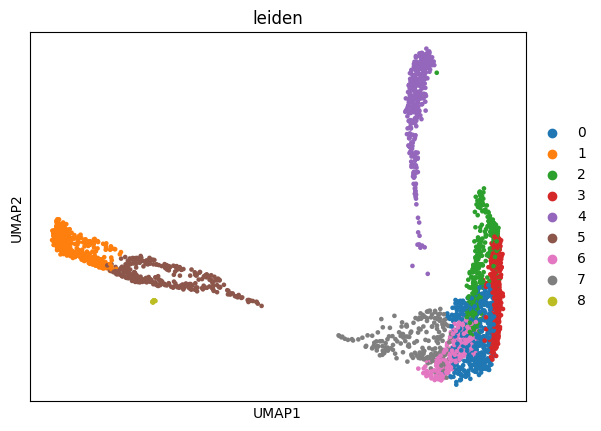

In [105]:
sc.pl.umap(grn_adata_smol, color='leiden')

Step 2: Cluster-Based Filtering

After applying global edge filtering, we further refine the GRN by performing cluster-based edge filtering. This step evaluates edges within individual clusters rather than across the entire dataset. The goal is to preserve edges that are consistently supported within clusters while removing edges that appear sporadically or inconsistently.

This procedure is especially useful when the GRN exhibits heterogeneous structure, as cluster-level filtering helps identify community-specific relationships and reduce noise.

Two parameters define how clusters are filtered:

percentage_1: The minimum fraction of cells within a cluster that must support an edge for it to be retained.\
percentage_2: The minimum fraction of clusters in which the edge must pass the percentage_1 threshold.

In [52]:
# Parameters setting
percentage_1 = 0.1
percentage_2 = 0.7
adata_orig = adata
#path_orig_data = os.path.join(use_case_path, "data.h5ad")
#adata_orig = sc.read_h5ad(path_orig_data)
print(f"Original data shape: {adata_orig}")

# Determine column for clustering mapping
#col_adata = "gene_1" if len(adata_orig.obs["gene_1"].unique()) == 2 else "gene_2"


Original data shape: AnnData object with n_obs × n_vars = 2700 × 960
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


In [53]:
del grn_adata_smol.layers['sorted']

In [54]:

# Additionally, we compare clustering solutions (e.g., leiden vs. spectral) to evaluate consistency between the GRN-based clusters and the original data.
add_top_edge_annotation_cluster(grn_adata_smol, top_edges=[top_edges], nan_fill=0, cluster_var="spectral")
print(f"Applying cluster cell count filter with percentage_1={percentage_1}, percentage_2={percentage_2}")


Successfully created layer 'sorted' using <class 'numpy.uint32'>.
Successfully created layer 'sorted' using <class 'numpy.uint32'>.
Successfully created layer 'sorted' using <class 'numpy.uint32'>.
Applying cluster cell count filter with percentage_1=0.1, percentage_2=0.7


In [55]:

grn_adata_smol = filter_clusters_by_cell_count(grn_adata_smol, percentage_1, percentage_2)
print(f"After cluster filter: {grn_adata_smol.shape}")

After cluster filter: (2700, 244894)


In [56]:
adata.obs['leiden']

index
AAACATACAACCAC-1    0
AAACATTGAGCTAC-1    2
AAACATTGATCAGC-1    0
AAACCGTGCTTCCG-1    1
AAACCGTGTATGCG-1    0
                   ..
TTTCGAACTCTCAT-1    1
TTTCTACTGAGGCA-1    0
TTTCTACTTCCTCG-1    2
TTTGCATGAGAGGC-1    2
TTTGCATGCCTCAC-1    0
Name: leiden, Length: 2700, dtype: category
Categories (3, object): ['0', '1', '2']

In [57]:
adata.obs['leiden']

index
AAACATACAACCAC-1    0
AAACATTGAGCTAC-1    2
AAACATTGATCAGC-1    0
AAACCGTGCTTCCG-1    1
AAACCGTGTATGCG-1    0
                   ..
TTTCGAACTCTCAT-1    1
TTTCTACTGAGGCA-1    0
TTTCTACTTCCTCG-1    2
TTTGCATGAGAGGC-1    2
TTTGCATGCCTCAC-1    0
Name: leiden, Length: 2700, dtype: category
Categories (3, object): ['0', '1', '2']

In [58]:
grn_adata_smol.obs['grn_orig'] = pd.Categorical(adata.obs['leiden'].values)

In [109]:
print("\nClustering Score Evaluation")
for col_grn in ["leiden", "spectral"]:
    key = f"{filter_key}__{col_grn}"
    score = unify_group_labelling(adata_orig, grn_adata_smol, 'leiden', col_grn)
    print(f"{col_grn} score: {score}")


Clustering Score Evaluation
leiden score: 0.5722222222222222
spectral score: 0.4


In [42]:
grn_adata_smol

AnnData object with n_obs × n_vars = 2700 × 244894
    obs: 'leiden', 'spectral', 'grn_orig', 'leiden_remap', 'spectral_remap'
    var: 'source', 'target', 'global_cell_count_0.1', 'cell_count_0.1_2', 'cell_count_0.1_0', 'cell_count_0.1_1'
    uns: 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Step 3: Selecting Top Targets per Source

In this step, we refine the GRN by selecting the top targets per source gene (TF), stratified by clusters. The goal is to:

Identify, for each regulator (source gene), its most strongly associated targets within each cluster.\
Ensure that regulatory “regions” (e.g., source–target modules) are of sufficient adequate size to be meaningful.\
Further prioritize regulatory signatures using a UCell-based scoring approach and keep only the highest-ranked regulators.

Key parameters:

cluster_column: The column in obs representing the cluster assignment used to stratify the analysis (here, "spectral").\
top_per_source: Maximum number of top-ranked targets to retain per source gene, within each cluster.\
min_reg_size: Minimum number of targets required for a regulator to be considered (i.e., minimal “region” size).\
keep_top: Number of top regulatory signatures (sources) to retain after UCell-based ranking.

The workflow consists of the following operations:

Synchronize cell/observation indices between adata_orig and grn_adata.\
Align cluster assignments between the original data and the GRN object.\
Use get_top_targets to select top targets per source, per cluster (subject to minimum size constraints).\
Compute UCell scores of regulatory signatures and filter to retain only the top-ranked sources.

In [212]:
# Set parameters
cluster_column = "leiden"
top_per_source = 100
min_reg_size = 14
keep_top = 20

# Ensure identical cell order between original data and GRN object
grn_adata_smol.obs_names = adata_orig.obs_names
# Remove existing cluster column in original data to avoid conflicts
if cluster_column in adata_orig.obs:
    adata_orig.obs.drop(columns=[cluster_column], inplace=True)

# Add the cluster assignments computed on the GRN data to the original AnnData
adata_orig.obs = adata_orig.obs.merge(grn_adata_smol.obs[[cluster_column]], left_index=True, right_index=True)
# Identify top targets for each source gene within clusters
# - Keeps up to top_per_source strongest targets
# - Removes regulons smaller than min_reg_size
grn_adata_smol_2, reglon_sizes = get_top_targets(gene_inter_adata=grn_adata_smol, adata=adata_orig, top_per_source=top_per_source, col_cluster=cluster_column, min_reg_size=min_reg_size, verbose=True)
# Compute UCell enrichment scores for each regulon signature
data_ucell = filter_signatures_by_Ucell(grn_adata_smol_2, adata_orig, ncores=ncores)
# Retain only the top-ranked regulons according to UCell signature enrichment
grn_adata_smol_2, top_sources = filter_grn_by_top_signatures(data_ucell, grn_adata_smol_2, keep_top_ranked=keep_top)

grn_adata_smol_2

Initial shape: (2700, 244894)
Ranking cluster: 0
Ranking cluster: 1
Ranking cluster: 2
Ranking cluster: 3
Ranking cluster: 4
Ranking cluster: 5
Ranking cluster: 6
Ranking cluster: 7
Ranking cluster: 8
Selecting targets for cluster: 0
Selecting targets for cluster: 1
Selecting targets for cluster: 2
Selecting targets for cluster: 3
Selecting targets for cluster: 4
Selecting targets for cluster: 5
Selecting targets for cluster: 6
Selecting targets for cluster: 7
Selecting targets for cluster: 8
Edges kept: 183966 unique
Filtered shape: (2700, 183966)
Unique sources: 960
After selecting top_per_source=100


AnnData object with n_obs × n_vars = 2700 × 2688
    obs: 'leiden', 'spectral', 'leiden_remap', 'spectral_remap', 'GSTO1_regulon', 'HLA-DMB_regulon', 'C1orf63_regulon', 'JUND_regulon', 'GADD45B_regulon', 'WTAP_regulon', 'MPC2_regulon', 'CCL3_regulon', 'AP3S1_regulon', 'GLTSCR2_regulon', 'RBMS1_regulon', 'ATP5D_regulon', 'EMB_regulon', 'HLA-DRA_regulon', 'SERPINA1_regulon', 'GYG1_regulon', 'ITGB7_regulon', 'PRPF38A_regulon', 'TIMM13_regulon', 'OAS1_regulon', 'CDV3_regulon', 'TBCB_regulon', 'TBCC_regulon', 'C4orf3_regulon', 'RASGRP2_regulon', 'NAA20_regulon', 'SF3B5_regulon', 'ABRACL_regulon', 'ATP5H_regulon', 'ANAPC16_regulon', 'JUN_regulon', 'SNX17_regulon', 'GABARAPL2_regulon', 'GBP2_regulon', 'CNPY2_regulon', 'APOA1BP_regulon', 'C1orf162_regulon', 'ADI1_regulon', 'MKKS_regulon', 'SPINT2_regulon', 'LAMTOR5_regulon', 'COPZ1_regulon', 'ARID4B_regulon', 'IFITM3_regulon', 'MYL6_regulon', 'CBX3_regulon', 'RPS27A_regulon', 'CRBN_regulon', 'RBCK1_regulon', 'ANXA2R_regulon', 'CD7_regulon'
   

In [213]:
del adata_regl

Constructing Regulon Activity AnnData

After selecting the top regulatory signatures and filtering the GRN, the next step is to compute regulon activity profiles across cells.\
This transforms the GRN into a cell-by-regulon matrix, where each entry quantifies the activity of a given regulon (source gene plus its selected targets) in an individual cell.

This step enables downstream analyses such as:

Comparing regulon activity across clusters or conditions\
Identifying key drivers of cell-state transitions\
Visualizing module-level patterns (e.g., UMAPs, heatmaps)\
Linking regulatory programs to phenotypes or metadata

In [222]:
# The function uses:
#   - grn_adata: the filtered GRN containing retained source–target modules
#   - data_ucell: UCell scores for regulatory signaturesspectral
#   - top_sources: the selected top-ranked regulators

adata_regl = create_regulon_activity_adata(grn_adata_smol_2, data_ucell, top_sources, )

# 1. Make sure spectral cluster labels are strings (and categorical)
#adata_regl.obs["leiden"] = adata_regl.obs["leiden"].astype(str)
#adata_regl.obs["leiden"] = adata_regl.obs["leiden"].astype("category")
#adata_regl

In [221]:
grn_adata_smol_2.obs = grn_adata_smol_2.obs.loc[:, ['leiden', 'spectral', 'spectral_remap', 'leiden_remap']]

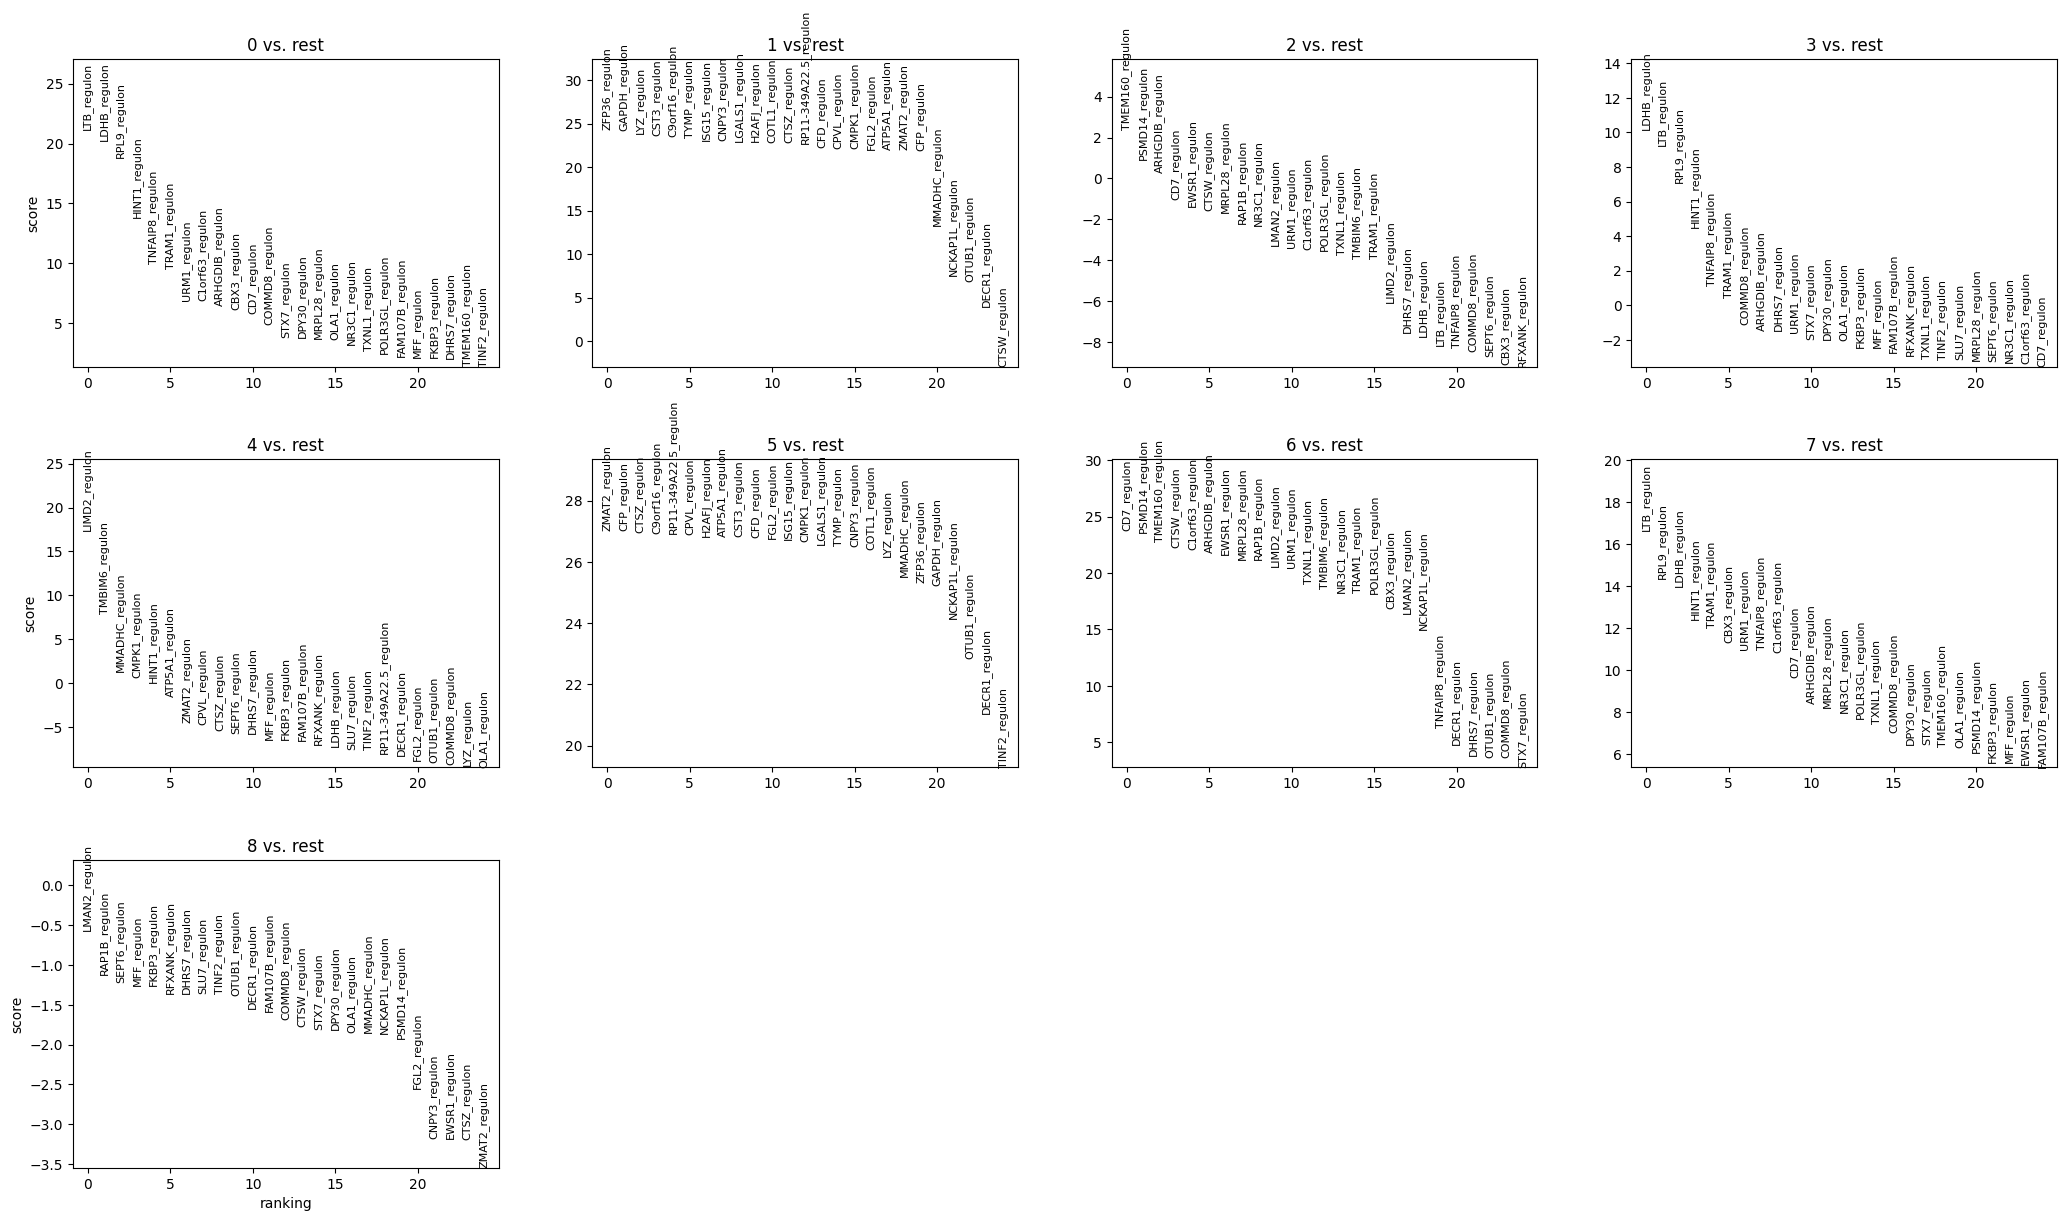

In [223]:
# Compute differential regulon activity using the nonparametric Wilcoxon test.
# This identifies regulons whose activity significantly differs between clusters.
sc.tl.rank_genes_groups(adata_regl, 'leiden', method='wilcoxon', key_added = "wilcoxon")

# Visualize the top differentially active regulons per cluster.
# The plot shows effect sizes and significance for the highest-ranked regulons.
sc.pl.rank_genes_groups(adata_regl, n_genes=25, sharey=False, key="wilcoxon")

In [224]:
adata_regl.obs

,leiden,spectral,spectral_remap,leiden_remap
index,,,,
AAACATACAACCAC-1,6,2,0,6
AAACATTGAGCTAC-1,4,2,0,3
AAACATTGATCAGC-1,0,2,0,1
AAACCGTGCTTCCG-1,1,0,2,2
AAACCGTGTATGCG-1,6,2,0,6
...,...,...,...,...
TTTCGAACTCTCAT-1,5,0,2,5
TTTCTACTGAGGCA-1,7,2,0,7
TTTCTACTTCCTCG-1,4,2,0,3


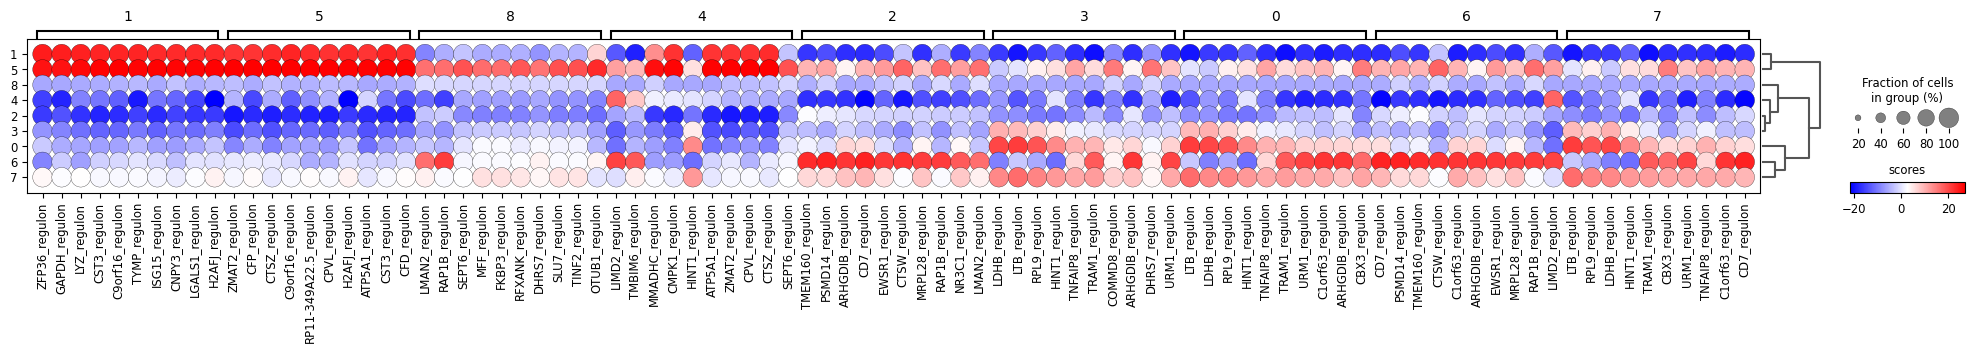

In [225]:
# Visualize the top 10 regulons per cluster using a dotplot.
sc.pl.rank_genes_groups_dotplot(adata_regl, n_genes=10, key="wilcoxon", groupby="leiden", cmap='bwr', figsize=(25, 2), values_to_plot="scores"  )

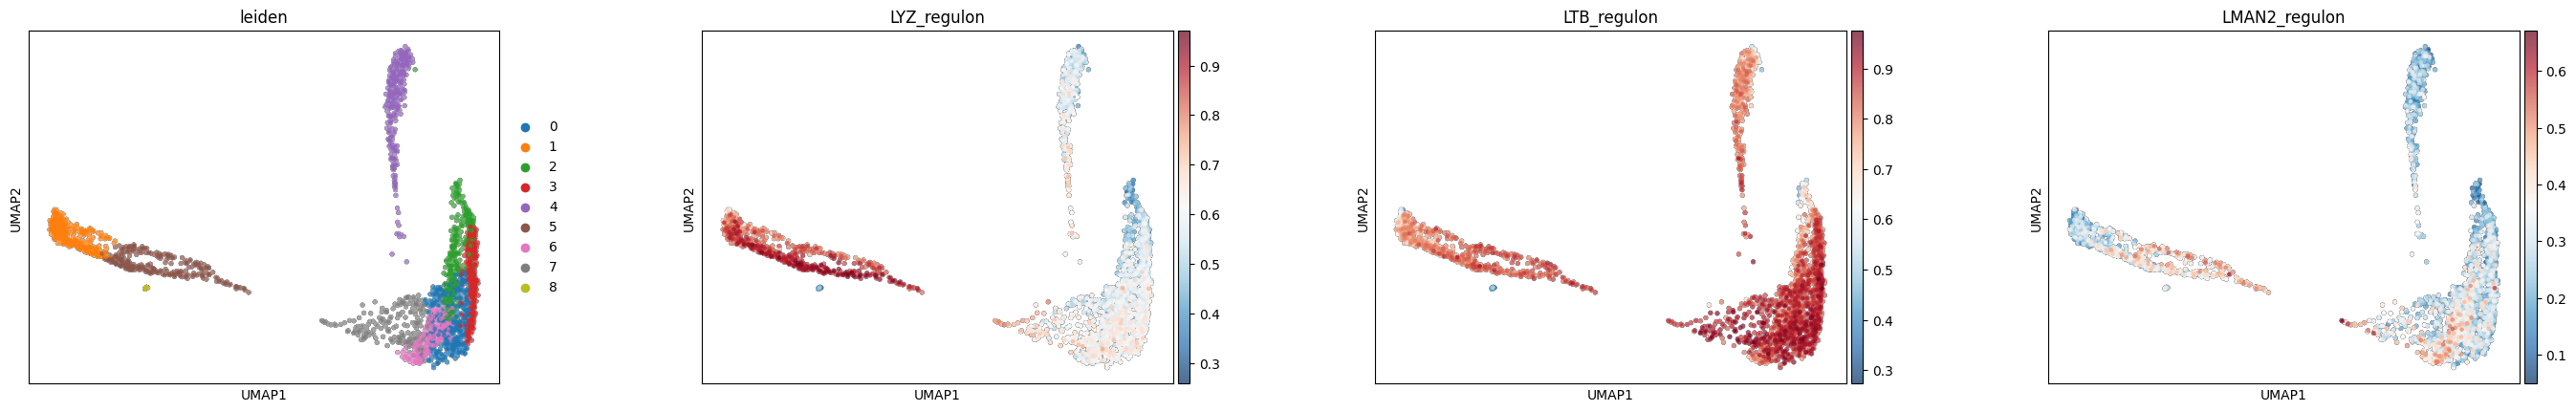

In [235]:
sc.pl.umap(grn_adata_smol, color=['leiden', 'LYZ_regulon', 'LTB_regulon', 'LMAN2_regulon'], wspace=0.3, cmap="RdBu_r", add_outline=True, outline_color=("black", "white"),outline_width=(0.05, 0))

In [150]:
import pandas as pd
import scipy.sparse

def merge_all_to_obs(target_adata, source_adata):
    """
    Takes all variables from source_adata and appends them as columns
    to target_adata.obs for easy plotting.
    """
    if target_adata.n_obs != source_adata.n_obs:
        raise ValueError("Cell counts do not match between objects.")

    # 1. Extract the data matrix
    # If it's sparse (common in single-cell), we must densify it to put it in .obs
    if scipy.sparse.issparse(source_adata.X):
        source_data = source_adata.X.toarray()
    else:
        source_data = source_adata.X

    # 2. Create a DataFrame from the source data
    source_df = pd.DataFrame(
        source_data, 
        index=source_adata.obs_names, 
        columns=source_adata.var_names
    )

    # 3. Concatenate with existing obs
    # We use axis=1 to join columns. 
    # verify_integrity=False is faster if you know the order is correct.
    target_adata.obs = pd.concat([target_adata.obs, source_df], axis=1)

    print(f"Added {source_df.shape[1]} columns to target_adata.obs")
    return target_adata

In [226]:
grn_adata_smol = merge_all_to_obs(grn_adata_smol, adata_regl)

Added 59 columns to target_adata.obs


In [160]:
adata_regl

AnnData object with n_obs × n_vars = 2700 × 51
    obs: 'leiden', 'spectral', 'grn_orig', 'leiden_remap', 'spectral_remap', 'GSTO1_regulon', 'HLA-DMB_regulon', 'C1orf63_regulon', 'JUND_regulon', 'GADD45B_regulon', 'WTAP_regulon', 'MPC2_regulon', 'CCL3_regulon', 'AP3S1_regulon', 'GLTSCR2_regulon', 'RBMS1_regulon', 'ATP5D_regulon', 'HLA-DRA_regulon', 'SERPINA1_regulon', 'GYG1_regulon', 'ITGB7_regulon', 'PRPF38A_regulon', 'OAS1_regulon', 'CDV3_regulon', 'TBCB_regulon', 'TBCC_regulon', 'C4orf3_regulon', 'RASGRP2_regulon', 'CD47_regulon', 'NAA20_regulon', 'SF3B5_regulon', 'ABRACL_regulon', 'ATP5H_regulon', 'ANAPC16_regulon', 'JUN_regulon', 'SNX17_regulon', 'GABARAPL2_regulon', 'GBP2_regulon', 'CNPY2_regulon', 'APOA1BP_regulon', 'C1orf162_regulon', 'ADI1_regulon', 'MKKS_regulon', 'SPINT2_regulon', 'LAMTOR5_regulon', 'COPZ1_regulon', 'ARID4B_regulon', 'IFITM3_regulon', 'MYL6_regulon', 'CBX3_regulon', 'RPS27A_regulon', 'CRBN_regulon', 'RBCK1_regulon', 'ANXA2R_regulon', 'CD7_regulon'
    obsm: 

In [152]:
adata = merge_all_to_obs(adata, adata_regl)

Added 51 columns to target_adata.obs


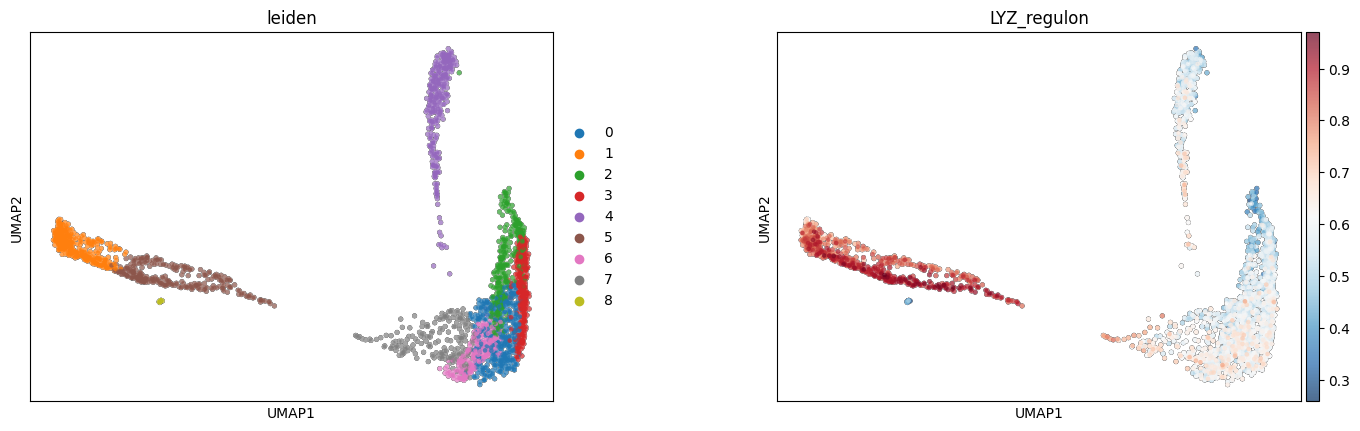

In [156]:
grn_adata_smol.obs = grn_adata_smol.obs.loc[:, ['leiden', 'spectral', 'leiden_remap', 'spectral_remap']]

TypeError: bad operand type for unary -: 'str'

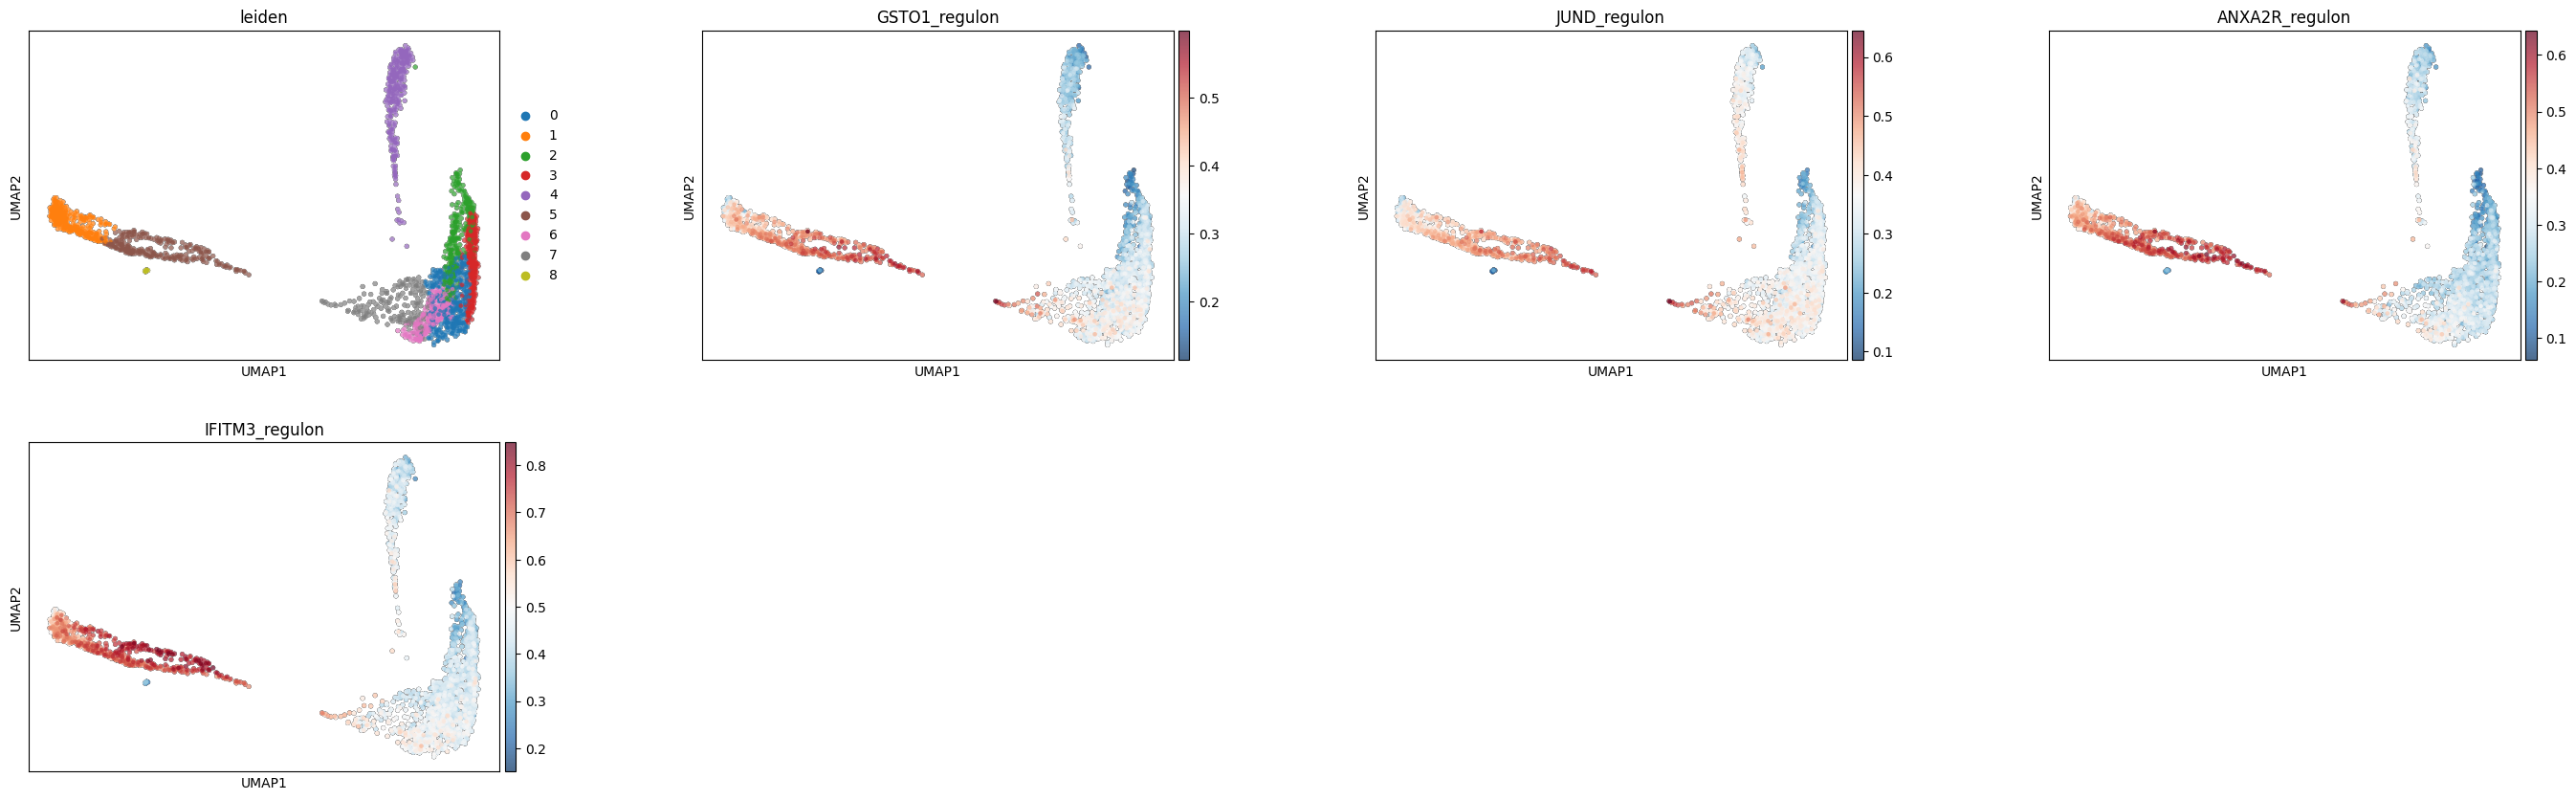

In [ ]:
# Each panel will appear as a separate row-group in the dotplot.
var_names = {'IFITM3_regulon': ['IFITM3_regulon'],}


sc.pl.rank_genes_groups_dotplot(
    adata_regl,
    var_names=var_names,          # your regulon panels
    key="wilcoxon",               # IMPORTANT: where DE results live
    groupby="leiden",           # must match the groupby used in rank_genes_groups
    values_to_plot="scores",
    cmap="bwr",
    vmin=-4,
    vmax=4,
    colorbar_title="scores",
    figsize=(10, 2)
)

TypeError: bad operand type for unary -: 'str'

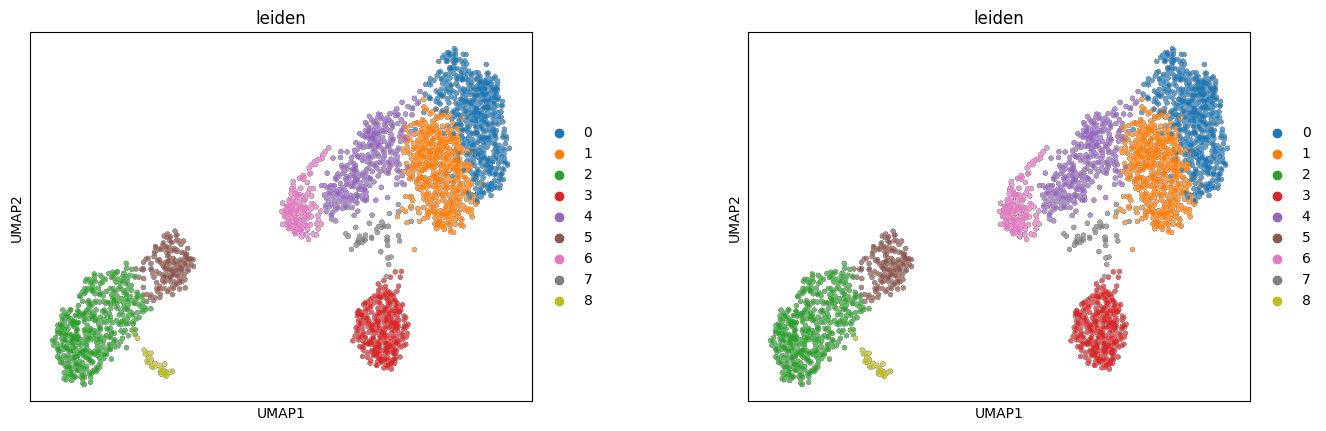

In [115]:
# UMAP visualization: clusters and regulon activity
#
# Purpose:
#   Visualize the regulon activity across cells, alongside the
#   cluster identities. This allows inspection of how strongly
#   a given regulon (e.g., CEBPA_regulon) is activated within
#   different cellular groups or states in the low-dimensional space.

sc.pl.umap(adata, color=[cluster_column, 'leiden', 'IFITM3_regulon'], wspace=0.3, cmap="RdBu_r", add_outline=True, outline_color=("black", "white"),outline_width=(0.05, 0))

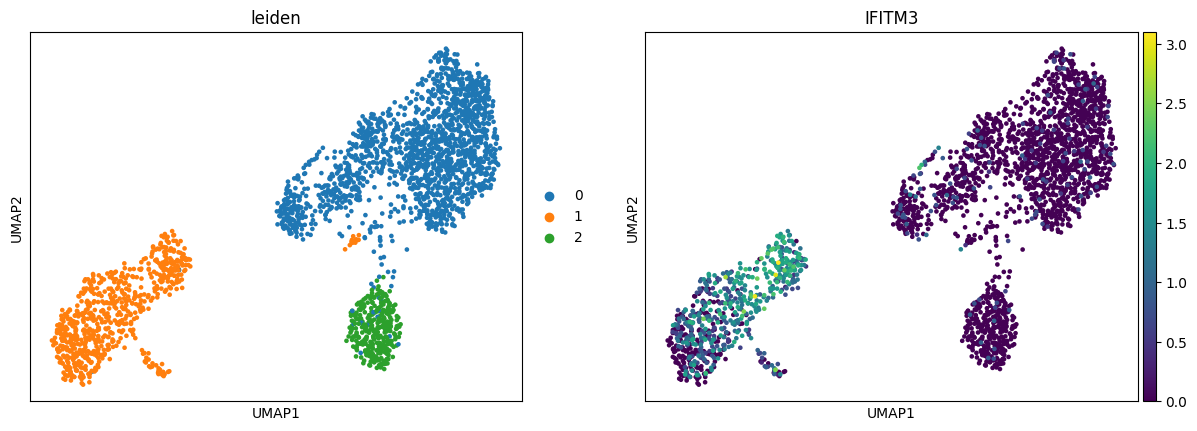

In [82]:
sc.pl.umap(adata, color=['leiden', 'IFITM3'])

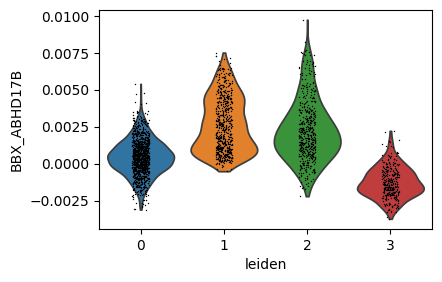

In [ ]:
# Violin plots: regulon activity distributions by cluster
# Purpose:
#   Visualize the distribution of selected regulon activities
#   across spectral clusters. Violin plots highlight differences
#   in median, variability, and overall activity patterns per group.

with rc_context({"figure.figsize": (4.5, 3)}):
    sc.pl.violin(grn_adata, ['BBX_ABHD17B'], groupby="leiden",use_raw=False)

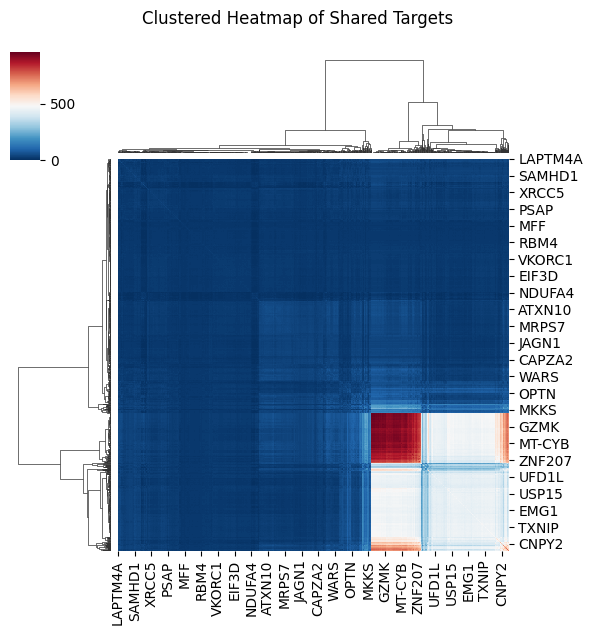

In [98]:
# Heatmap: shared targets between regulons
#
# Purpose:
#   Visualize the overlap in target genes between regulons.
#   This heatmap highlights:
#       - which regulons share many downstream targets,
#       - potential co-regulatory modules,
#       - redundancies or functional similarity among regulators.

plot_shared_targets_heatmap(grn_adata_smol, genes=None, figsize=(6, 6), cmap='RdBu_r',
                                metric='euclidean', method='average', title='Clustered Heatmap of Shared Targets')

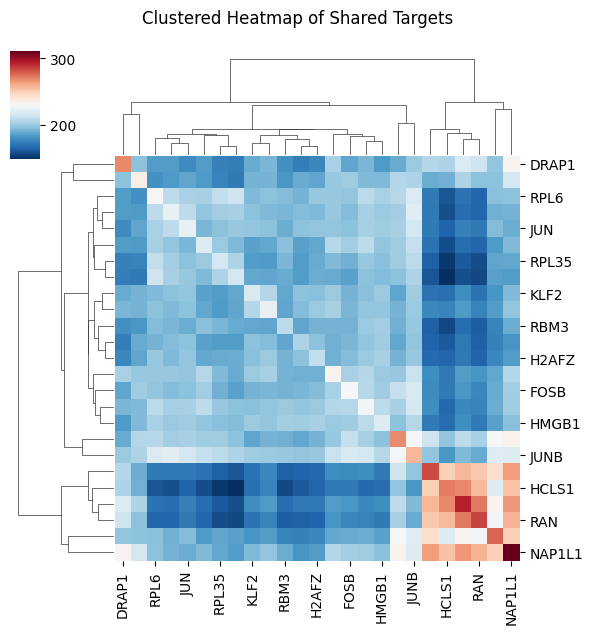

In [ ]:
# Using only a subset of genes for clarity
plot_shared_targets_heatmap(grn_adata, genes=grn_adata.var["source"].unique()[:25], figsize=(6, 6), cmap='RdBu_r',
                                metric='euclidean', method='average', title='Clustered Heatmap of Shared Targets')

## Networks Analysis

In [ ]:
# Plot a single regulon network
# Purpose:
#   Visualize the regulatory network associated with a specific
#   transcription factor (here: CEBPA). The plot typically includes
#   the source regulator and its top downstream targets, allowing
#   inspection of connectivity, target density, and regulatory structure.

plot_reg(grn_adata, regulon=["TPI1"], name="TPI1_regulon", out_path=output_dir)

['TPI1']
(285, 5)
path: /data_nfs/og86asub/netmap/netmap-evaluation/netmap/tutorials/use_case_outputs/networks/TPI1_regulon.html
/data_nfs/og86asub/netmap/netmap-evaluation/netmap/tutorials/use_case_outputs/networks/TPI1_regulon.html


In [ ]:
# Curate regulatory network using CollecTRI
# Purpose:
#   Refine the inferred CEBPA regulon using CollecTRI, a curated
#   database of transcription factor–target interactions. This step
#   filters the network to retain only experimentally supported or
#   high-confidence edges for the specified TF(s).


net_df_curated = curate_network(grn_adata, organism="human", tfs=["CEBPA"])
net_df_curated

NameError: name 'op' is not defined

In [ ]:
# Plot curated CEBPA regulon network
# Purpose:
#   Visualize the curated CEBPA regulon derived from CollecTRI.
#   This plot focuses exclusively on high-confidence regulatory
#   interactions, providing a cleaner and more biologically supported
#   network structure compared to the full inferred regulon.

plot_reg_curated(net_df_curated, regulon=["CEBPA"], name="CEBPA_network_curated", out_path=output_dir)

NameError: name 'net_df_curated' is not defined

In [ ]:
from netmap.downstream.gene_clustering import *

In [ ]:
df, dist_linkage = get_hierarchical_clustering(adata, genes=None)

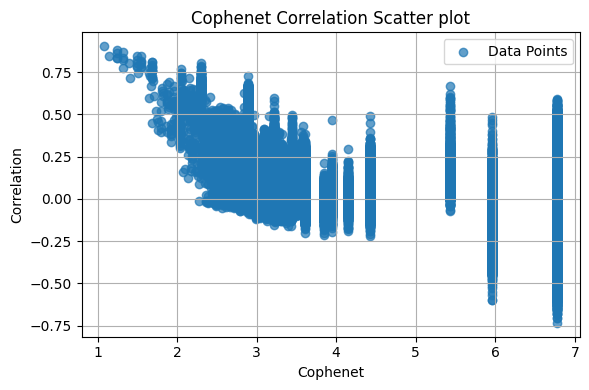

In [ ]:
plot_scatter_plot(df)

Automatically determined cluster cutoff distance: 1.6066


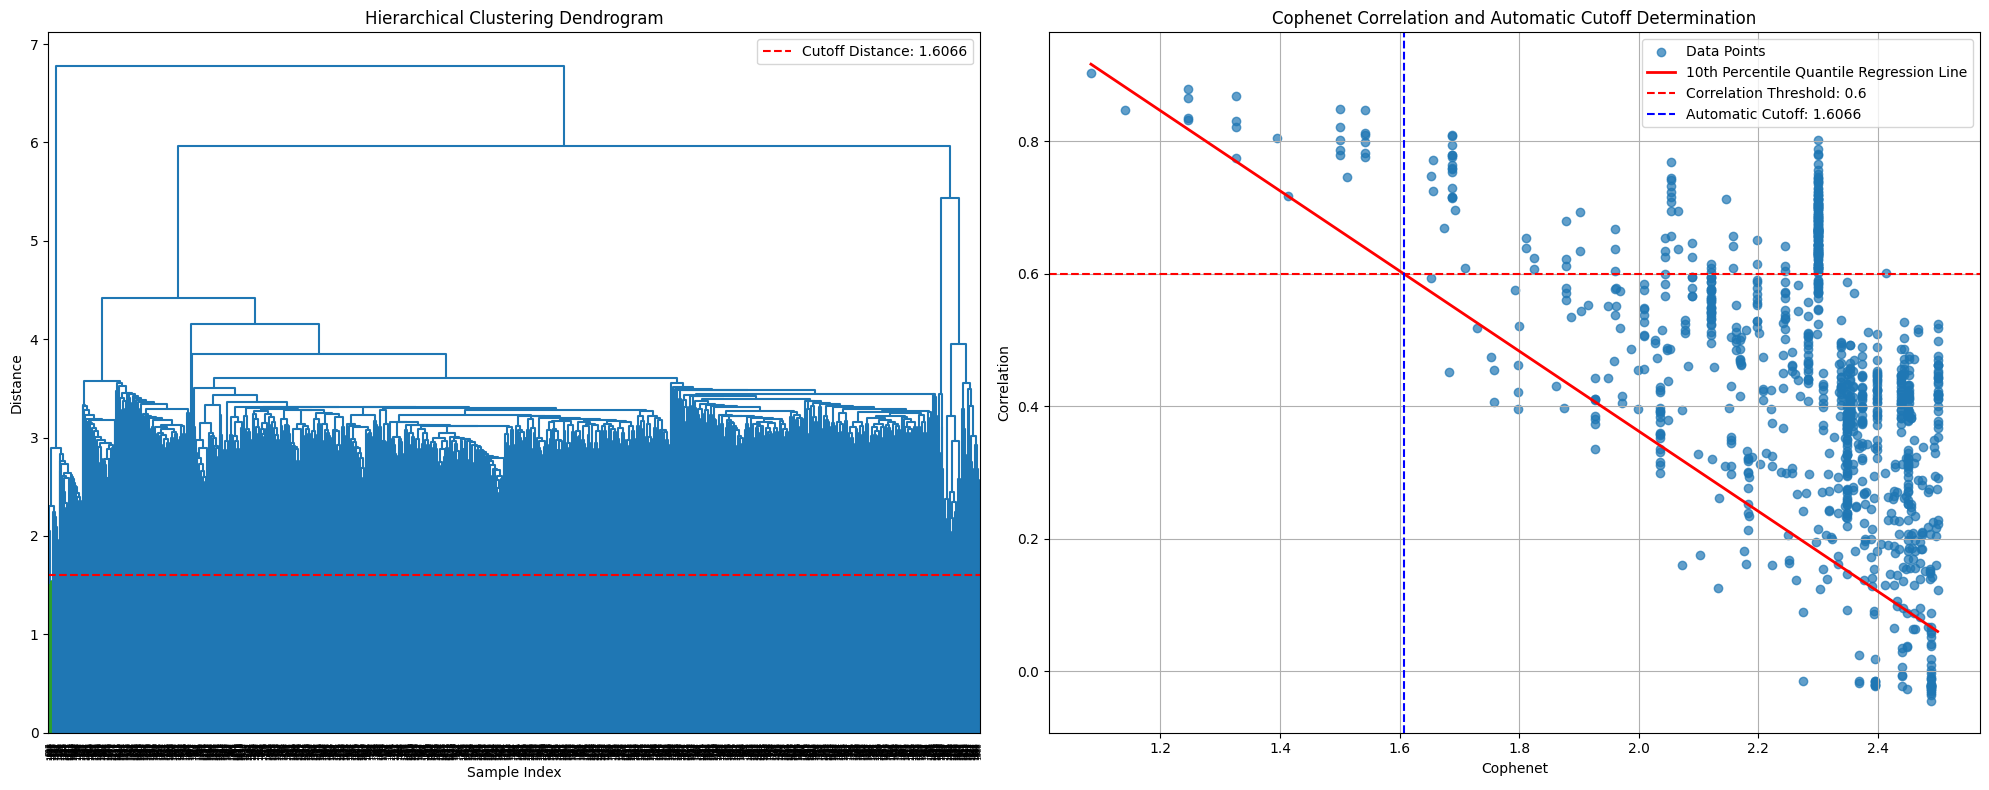

In [ ]:
cutoff = compute_regression(df, 2.5, dist_linkage = dist_linkage)

In [ ]:
adata = add_clusters_to_adata(adata, cutoff_distance=cutoff, dist_linkage=dist_linkage, cluster_var='target_cluster')
#scgenerai.var = scgenerai.var.merge(ref_adata.var, left_on='target', right_on= 'genes')

In [ ]:
adata

AnnData object with n_obs × n_vars = 738 × 2000
    obs: 'barcode', 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_identity_', 'gene_1', 'gene_2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'Ensembl_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'target_cluster'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [ ]:
adata

AnnData object with n_obs × n_vars = 738 × 2000
    obs: 'barcode', 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_identity_', 'gene_1', 'gene_2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'Ensembl_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'target_cluster'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'